In [21]:
# credits to KEVIN DWYER at http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/ for this tutorial
# code for this entire notebook is copied and/or modified from his tutorial and is being used for learning and practice purposes
import fiona
import shapely.geometry as geometry
input_shapefile = r'C:\Users\sujay\OneDrive\EECS 280 Round 2\Documents\GeoSpatial\GeoSpatialPractice\data\concave_demo_points.shp'
shapefile = fiona.open(input_shapefile)
points = [geometry.shape(point['geometry'])
          for point in shapefile]



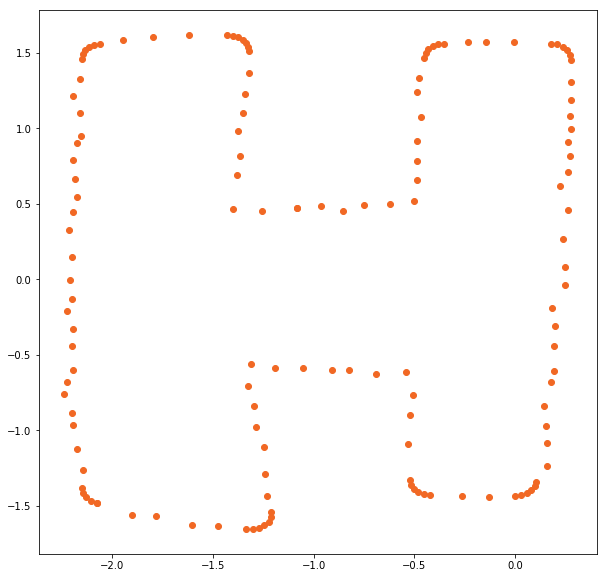

In [22]:
import pylab as pl
x = [p.coords.xy[0] for p in points]
y = [p.coords.xy[1] for p in points]
pl.figure(figsize=(10,10))
_ = pl.plot(x,y,'o', color='#f16824')

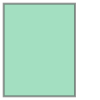

In [23]:
point_collection = geometry.MultiPoint(list(points))
point_collection.envelope

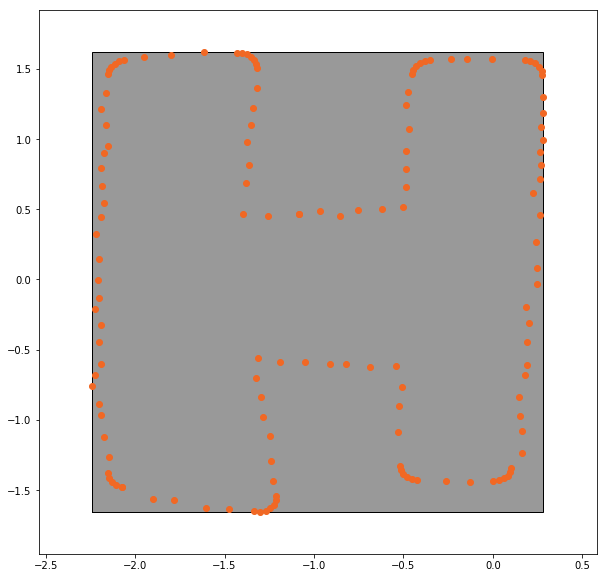

In [24]:
from descartes import PolygonPatch 
def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = 0.3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True, 
                         zorder=-1)
    ax.add_patch(patch)
    return fig

_ = plot_polygon(point_collection.envelope)
_ = pl.plot(x,y,'o', color='#f16824')

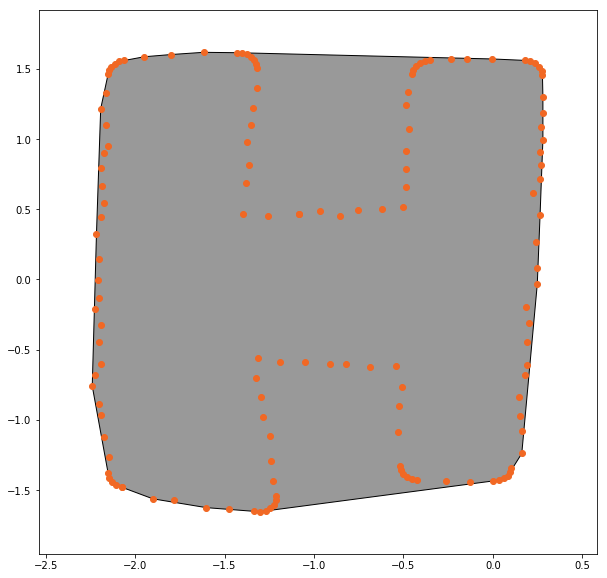

In [25]:
convex_hull_polygon = point_collection.convex_hull
_ = plot_polygon(convex_hull_polygon)
_ = pl.plot(x,y,'o', color='#f16824')

NameError: name 'pl' is not defined

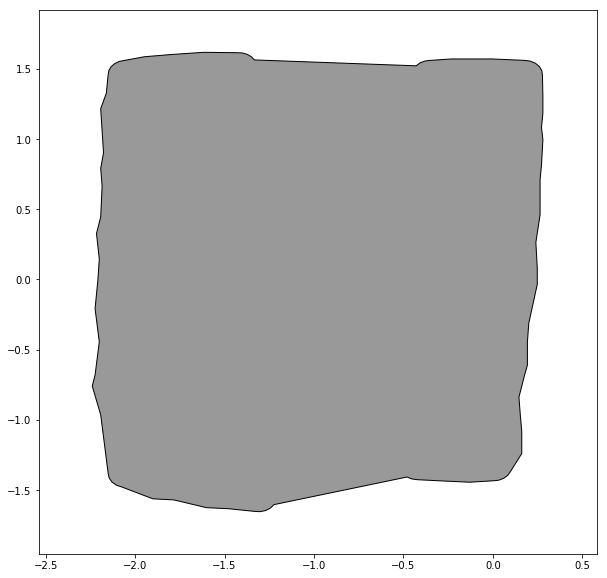

In [26]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add((i, j))
        edge_points.append(coords[[i, j]])
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()   
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        # print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
concave_hull, edge_points = alpha_shape(points, alpha=1.87)
_ = plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')

In [ ]:
input_shapefile = r'C:\Users\sujay\OneDrive\EECS 280 Round 2\Documents\GeoSpatial\GeoSpatialPractice\data\demo_poly_scaled_points_join.shp'
new_shapefile = fiona.open(input_shapefile)
new_points = [geometry.shape(point['geometry'])
              for point in new_shapefile]
x = [p.coords.xy[0] for p in new_points]
y = [p.coords.xy[1] for p in new_points]
pl.figure(figsize=(10,10))
_ = pl.plot(x,y,'o', color='#f16824')

In [27]:
from matplotlib.collections import LineCollection
for i in range(9):
    alpha = (i+1)*.1
    concave_hull, edge_points = alpha_shape(new_points, alpha=alpha)
    #print concave_hull
    lines = LineCollection(edge_points)
    pl.figure(figsize=(10,10))
    pl.title('Alpha={0} Delaunay triangulation'.format(alpha))
    pl.gca().add_collection(lines)
    delaunay_points = np.array([point.coords[0] for point in new_points])
    pl.plot(delaunay_points[:,0], delaunay_points[:,1],'o', hold=1, color='#f16824')

    _ = plot_polygon(concave_hull)
    _ = pl.plot(x,y,'o', color='#f16824')

NameError: name 'new_points' is not defined

In [ ]:
alpha = .4
concave_hull, edge_points = alpha_shape(new_points, alpha=alpha)

plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')
plot_polygon(concave_hull.buffer(1))
_ = pl.plot(x,y,'o', color='#f16824')